### Imports

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from os import listdir
from pathlib import Path

### 1. Functions for cleaning data

#### 1.1 Clean and convert to right datatypes

In [2]:
def clean_data(df):
    on_off_regex = '[^(]*\(([0-9])\).*'
    state_regex = "([^ ]*) \(([0-9])\)"

    df['beam_is_on'] = df['beam_is_on'].str.extract(on_off_regex)
    df['beam_is_on'] = pd.to_numeric(df['beam_is_on'])
    df['service_mode_is_on'] = df['service_mode_is_on'].str.extract(on_off_regex)
    df['service_mode_is_on'] = pd.to_numeric(df['service_mode_is_on'])
    df['server_watchdog'] = pd.to_numeric(df['server_watchdog'])

    # # Split 'External state' to two new columns
    df['external_state'] = df['external_state'].fillna(method='ffill')
    df[['external_state_name','external_state_num']] = df['external_state'].str.extract(state_regex, expand=True)
    df = df.drop(['external_state','external_state_name'], axis=1)
    df['external_state_num'] = pd.to_numeric(df['external_state_num'])

    df['external_state_num'] = np.where(df['external_state_num'] != 4.0, 0, 1)
    return df

#### 1.2 Fill NaN values

In [3]:
# Pandas fillna methods:
#  pad / ffill: propagate last valid observation forward to next valid (until new values is found, propagates last valid value forward)
#  backfill / bfill: use next valid observation to fill gap. 

def fill_na_values(df):
    def get_opposite_value(x): return 1 if int(x) == 0 else 0

    df = df.sort_values(by='date_time', ascending=True)

    first_valid_beam = df['beam_is_on'].dropna().iloc(0)[0]
    df['beam_is_on'] = df['beam_is_on'].fillna(method='ffill')
    df['beam_is_on'] = df['beam_is_on'].fillna(get_opposite_value(first_valid_beam)).astype('int32')


    first_valid_blank = df['is_blanked'].dropna().iloc(0)[0]
    df['is_blanked'] = df['is_blanked'].fillna(method='ffill')
    df['is_blanked'] = df['is_blanked'].fillna(get_opposite_value(first_valid_blank)).astype('int32')

    first_valid_server = df['server_watchdog'].dropna().iloc(0)[0]
    df['server_watchdog'] = df['server_watchdog'].fillna(method='ffill')
    df['server_watchdog'] = df['server_watchdog'].fillna(get_opposite_value(first_valid_server)).astype('int32')

    first_valid_service_mode = df['service_mode_is_on'].dropna().iloc(0)[0]
    df['service_mode_is_on'] = df['service_mode_is_on'].fillna(method='ffill')
    df['service_mode_is_on'] = df['service_mode_is_on'].fillna(get_opposite_value(first_valid_service_mode)).astype('int32')
    
    return df

#### 1.3 Drop consecutive duplicates

In [4]:
def drop_consecutive_duplicates(df):
    cols = ['server_watchdog','beam_is_on','external_state_num','is_blanked','service_mode_is_on']
    f = df[cols].ne(df[cols].shift()).any(1)
    return df[f]


#### 1.4 Add new columns

In [5]:
def add_new_columns(df):
    df['day_of_week'] = df['date_time'].dt.day_name()
    df['hour'] = df['date_time'].dt.hour

    df['server_watchdog_changed'] = df['server_watchdog'].diff().astype(bool)
    df['beam_is_on_changed'] = df['beam_is_on'].diff().astype(bool)
    df['external_state_num_changed'] = df['external_state_num'].diff().astype(bool)
    df['is_blanked_changed'] = df['is_blanked'].diff().astype(bool)
    df['service_mode_is_on_changed'] = df['service_mode_is_on'].diff().astype(bool)
    
    # State duration
    df['duration_of_state'] = df['date_time'].diff().shift(-1)
    
    # Microscope is working
    df['is_working'] = (df['external_state_num'] == 1) & (df['beam_is_on'] == 1) & (df['is_blanked'] == 0) & (df['service_mode_is_on'] == 0)
    df['working_while_in_service'] = (df['service_mode_is_on']==1) & (df['external_state_num']==1)
    df['blanked_while_beam_is_on'] = (df['beam_is_on']==1) & (df['is_blanked']==1)
    
    return df



# 3. Main

In [6]:
input_path = Path('data_raw/')
output_path = Path('data_clean/')

# overall_start = datetime.now()
# print(f"Overall start {overall_start}")

filepaths = [f for f in listdir(input_path) if f.endswith('.csv')]

# read multiple files
dfs = []
for file in filepaths:
#     file_start = datetime.now()
#     print(f"{file} start {file_start}")
    
    columns = ['date','time','server_watchdog','beam_is_on','external_state','is_blanked','service_mode_is_on']
    df = pd.read_csv(input_path / file, skiprows=11, names=columns, parse_dates=[['date','time']])
    df.insert(0,'Microscope',file.rstrip('.csv'))
    df = clean_data(df)
    df = fill_na_values(df)
    df = drop_consecutive_duplicates(df)
    df = add_new_columns(df)
    
    #df.to_csv(output_path / file, index=False, decimal=',')
    
#     file_end = datetime.now()
#     print(f"{file} end {file_end}")
#     print(f"{file} duration: {(file_end - file_start).seconds}")
    
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
#df.to_csv('concat_data.csv', index=False, decimal=',')

# overall_end = datetime.now()
# print(f"Overall end {overall_end}")
# print(f"Overall duration: {(overall_end - overall_start).seconds}")
df

,Microscope,date_time,server_watchdog,beam_is_on,is_blanked,service_mode_is_on,external_state_num,day_of_week,hour,server_watchdog_changed,beam_is_on_changed,external_state_num_changed,is_blanked_changed,service_mode_is_on_changed,duration_of_state,is_working,working_while_in_service,blanked_while_beam_is_on
0,System 1,2020-11-25 08:00:23.130,1,0,1,1,0,Wednesday,8,True,True,True,True,True,0 days 00:35:33.520000,False,False,False
1,System 1,2020-11-25 08:35:56.650,1,0,1,0,0,Wednesday,8,False,False,False,False,True,0 days 00:00:23.423000,False,False,False
2,System 1,2020-11-25 08:36:20.073,1,0,1,0,1,Wednesday,8,False,False,True,False,False,0 days 00:00:03.425000,False,False,False
3,System 1,2020-11-25 08:36:23.498,1,1,1,0,1,Wednesday,8,False,True,False,False,False,0 days 00:51:17.095000,False,False,True
4,System 1,2020-11-25 09:27:40.593,1,1,1,0,0,Wednesday,9,False,False,True,False,False,0 days 00:00:02.111000,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5555328,System 9,2021-02-05 14:56:38.158,1,1,0,0,1,Friday,14,False,False,False,True,False,0 days 00:00:00.568000,True,False,False
5555329,System 9,2021-02-05 14:56:38.726,1,1,1,0,1,Friday,14,False,False,False,True,False,0 days 00:00:02.278000,False,False,True
5555330,System 9,2021-02-05 14:56:41.004,1,1,0,0,1,Friday,14,False,False,False,True,False,0 days 00:00:03.467000,True,False,False
5555331,System 9,2021-02-05 14:56:44.471,1,1,1,0,1,Friday,14,False,False,False,True,False,0 days 00:00:08.670000,False,False,True


## 3. Visualization

In [71]:
microscopes = {f'M{i}':dfs[i-1] for i in range (1,10)}

#### Working time by microscope (%)

M1: Total working time 3 days 10:45:13.288000	for total period in dataset 89 days 02:47:27.925000 (3.87%)
M2: Total working time 39 days 10:57:18.753000	for total period in dataset 366 days 11:53:32.979000 (10.77%)
M3: Total working time 2 days 22:39:02.344000	for total period in dataset 122 days 23:59:10.205000 (2.39%)
M4: Total working time 34 days 21:38:56.336000	for total period in dataset 122 days 23:59:47.713000 (28.38%)
M5: Total working time 35 days 22:15:16.882000	for total period in dataset 122 days 23:59:31.011000 (29.21%)
M6: Total working time 2 days 18:00:58.886000	for total period in dataset 122 days 11:22:35.752000 (2.25%)
M7: Total working time 28 days 17:15:38.596000	for total period in dataset 104 days 12:00:15.375000 (27.48%)
M8: Total working time 2 days 01:01:13.886000	for total period in dataset 223 days 20:50:29.366000 (0.91%)
M9: Total working time 36 days 10:38:56.978000	for total period in dataset 122 days 23:57:11.823000 (29.63%)


<AxesSubplot:title={'center':'Worked time in %'}>

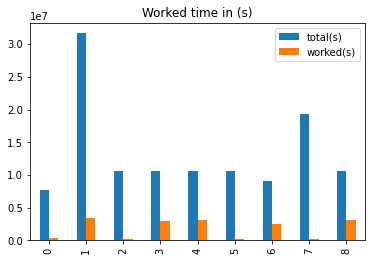

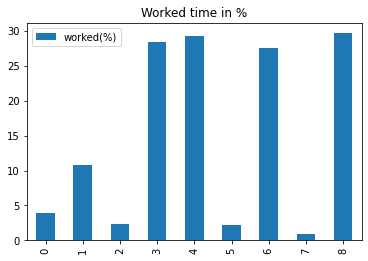

In [73]:
total_times=[]
worked_times=[]
worked_times_percents=[]

for name, df in microscopes.items():
    is_working = df[(df['is_working'])]
    total_time = df['duration_of_state'].sum()
    total_worked_time = is_working['duration_of_state'].sum()
    
    worked_time_percent = round(total_worked_time/total_time * 100,2)
    print(f'{name}: Total working time {total_worked_time}\tfor total period in dataset {total_time} ({worked_time_percent}%)')
    total_times.append(total_time.total_seconds())
    worked_times.append(total_worked_time.total_seconds())
    worked_times_percents.append(worked_time_percent)
    

df = pd.DataFrame({'total(s)':total_times,'worked(s)':worked_times})
df.plot.bar(title='Worked time in (s)')

df2 = pd.DataFrame({'worked(%)':worked_times_percents})
df2.plot.bar(title='Worked time in %')

#### Service time by microscope (%)

<AxesSubplot:title={'center':'Service time in (%)'}>

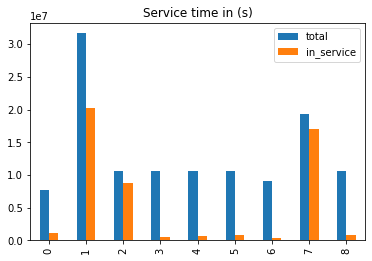

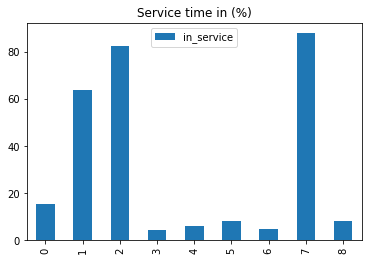

In [45]:
in_service = []
in_service_percent = []

for df, total_time in zip(dfs, total_times):
    df['service_mode_is_on'] = df['service_mode_is_on'].astype(bool)
    is_in_service = df[(df['service_mode_is_on'])]
    
    service_time = is_in_service['duration_of_state'].sum().total_seconds()
    
    service_time_percent = round(service_time/total_time * 100,2)
    
    in_service.append(service_time)
    in_service_percent.append(service_time_percent)

    
df = pd.DataFrame({'total':total_times,'in_service':in_service})
df.plot.bar(title='Service time in (s)')

df2 = pd.DataFrame({'in_service':in_service_percent})
df2.plot.bar(title='Service time in (%)')


#### Optimalizations

M1: Duration of beam on while blanked 14 days 04:39:37.425000
M2: Duration of beam on while blanked 51 days 13:37:38.827000
M3: Duration of beam on while blanked 41 days 11:56:54.896000
M4: Duration of beam on while blanked 46 days 11:26:25.719000
M5: Duration of beam on while blanked 52 days 09:28:00.349000
M6: Duration of beam on while blanked 8 days 03:22:17.574000
M7: Duration of beam on while blanked 39 days 21:49:17.715000
M8: Duration of beam on while blanked 39 days 18:10:52.306000
M9: Duration of beam on while blanked 48 days 08:29:35.173000


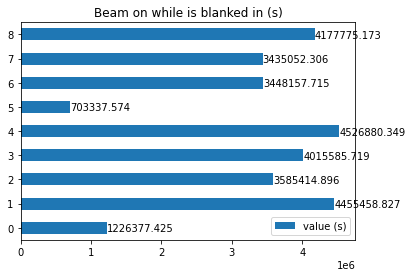

In [75]:
totals_time = []

for name, df in microscopes.items():
    blanked_while_beam_on = df[(df['blanked_while_beam_is_on'])]
    total_time = blanked_while_beam_on['duration_of_state'].sum()
    print(f'{name}: Duration of beam on while blanked {total_time}')
    totals_time.append(total_time.total_seconds())

df2 = pd.DataFrame({'value (s)':totals_time})
graph = df2.plot.barh(title='Beam on while is blanked in (s)')


for i in graph.patches:
    totals.append(i.get_width())
    
for i, time in zip(graph.patches, totals_time):
    # get_width pulls left or right; get_y pushes up or down
    graph.text(i.get_width()+.3, i.get_y()+.1, str(time))

In [77]:
for name, df in microscopes.items():
    working_in_service = df[(df['working_while_in_service'])]
    time = working_in_service['duration_of_state'].sum()
    print(f"{name}: Worked while in service {time}")

M1: Worked while in service 12 days 14:56:18.060000
M2: Worked while in service 227 days 06:42:06.824000
M3: Worked while in service 94 days 07:04:59.472000
M4: Worked while in service 2 days 14:35:17.758000
M5: Worked while in service 5 days 10:53:01.494000
M6: Worked while in service 9 days 19:35:48.403000
M7: Worked while in service 3 days 15:46:31.136000
M8: Worked while in service 182 days 16:57:40.536000
M9: Worked while in service 8 days 09:07:54.341000
